# Glyph Generator MLP 🔡

This notebook defines a minimal multilayer perceptron (MLP) that learns to draw characters. 
Each character is associated with a glyph image, and the model learns to generate those images from learned embeddings.

Inspired by Karpathy's tiny deep learning experiments, this project draws each letter from scratch by learning to map from a symbolic character embedding to its pixel representation.


## 1. Font Preprocessing

Load a `.ttf` font and rasterize each character into a fixed resolution grayscale image. 

We normalize pixel values so that **black = 1.0** and **white = 0.0**.

In [1]:
def process_font(ttf_path, n):
    from PIL import Image, ImageDraw, ImageFont
    import numpy as np
    import torch

    font = ImageFont.truetype(ttf_path, size=100)
    chars = "abcdefghijklmnopqrstuvwxyz"
    out = {}
    for ch in chars:
        bbox = font.getbbox(ch)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        img = Image.new("L", (w + 10, h + 10), 255)
        draw = ImageDraw.Draw(img)
        draw.text((5 - bbox[0], 5 - bbox[1]), ch, font=font, fill=0)
        arr = np.array(img)
        rows = np.where(np.any(arr < 255, axis=1))[0]
        cols = np.where(np.any(arr < 255, axis=0))[0]
        if rows.size and cols.size:
            arr = arr[rows[0]:rows[-1] + 1, cols[0]:cols[-1] + 1]
        cropped = Image.fromarray(arr)
        resized = cropped.resize((n, n), resample=Image.BILINEAR)
        out[ch] = torch.from_numpy(np.array(resized)).float()
    return out

## 2. Initialize and Visualize Glyphs

In [2]:
font = '../data/demo_font.ttf'
fonts = process_font(font, 20)

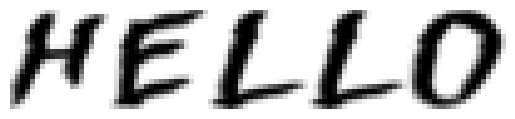

In [3]:
import numpy as np
import matplotlib.pyplot as plt
composite = np.hstack([fonts[c] for c in 'hello'])
plt.imshow(composite, cmap='gray')
plt.axis('off')
plt.show()

# Normalize glyphs: values close to 0 for white, 1 for black.

In [4]:
char_to_pix = {k: ((255 - fonts[k]) / 255) for k in fonts.keys()}
pix_len = char_to_pix['a'].view(-1).shape[0]
input_dim = len(char_to_pix)
print(f"{pix_len} pixels")
print(f"{input_dim} chars (input_dim)")

400 pixels
26 chars (input_dim)


## 3. Build MLP from Scratch

In [5]:
import torch
import torch.nn.functional as F
import math
import string

g = torch.Generator().manual_seed(1337)

class Linear:
    def __init__(self, in_features, out_features, bias=True):
        if hasattr(in_features, 'out_features'):
            in_features = in_features.out_features
        self.in_features = in_features
        self.out_features = out_features
        k = math.sqrt(1 / in_features)
        self.weight = torch.empty(out_features, in_features).uniform_(-k, k, generator=g)
        self.bias = torch.empty(out_features).uniform_(-k, k, generator=g) if bias else None

    def __call__(self, incoming):
        out = incoming @ self.weight.T
        if self.bias is not None:
            out += self.bias
        return out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Gelu:
    def __call__(self, x):
        self.out = F.gelu(x)
        return self.out
    def parameters(self):
        return []


## 4. Initialize Embedding Table & Model Layers

In [6]:
n_embd = 50
C = torch.randn((input_dim, n_embd))  # embedding for each character

layers = [
    Linear(n_embd, 100), Gelu(),
    Linear(100, 200), Gelu(),
    Linear(200, 300), Gelu(),
    Linear(300, 400), Gelu(),    # final output: 400 pixels (20x20)
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total params: 207300


## 5. Define Forward Pass

In [7]:
def forward(x):
    for layer in layers:
        x = layer(x)
    return x

## 6. Train the Model

For each character, pass its embedding through the model and compare the output to its target glyph.

In [8]:
for step in range(5000):
    losses = []

    for i in range(26):
        emb = C[i]  # embedding for char i
        target = char_to_pix[string.ascii_lowercase[i]].view(-1)
        pred = forward(emb)
        loss = F.mse_loss(pred, target)
        losses.append(loss)
        loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad
        p.grad = None

    if step % 1000 == 0:
        print(f"step {step}: avg loss {sum(losses).item() / len(losses):.6f}")

step 0: avg loss 0.251507
step 1000: avg loss 0.000207
step 2000: avg loss 0.000012
step 3000: avg loss 0.000002
step 4000: avg loss 0.000001


## 7. Visualize a Generated Glyph

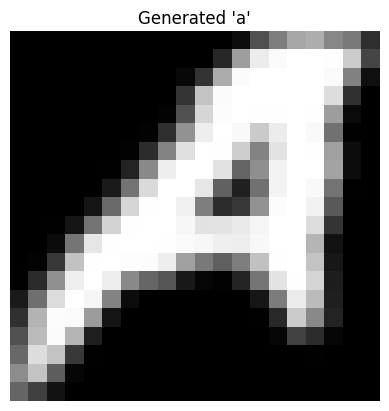

In [9]:
pred = forward(C[0])  # character 'a'
plt.imshow(pred.view(20, 20).detach(), cmap='gray')
plt.title("Generated 'a'")
plt.axis('off')
plt.show()